In [1]:
%matplotlib notebook
#%matplotlib inline
import sys
sys.path.append("../../NephNet")
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm
from data_loader import data_loaders as module_data
from model import loss as module_loss
from model import metric as module_metric
from model import model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import tSNE_test as tSNE#import Identity, tSNE_generator
from utils import torchsummary
from utils import viewTraining
from utils import lr_finder
from utils import classActivationMap
import importlib
import math
import torchvision
from torch.nn import functional as F
from torch import topk
import skimage.transform
import jupyter
from IPython import display
from ipywidgets import *
from utils import hyperband as HypOpt
import argparse
print("Modules loaded")


importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(tSNE)
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(module_metric)
importlib.reload(util)
importlib.reload(viewTraining)
importlib.reload(lr_finder)
importlib.reload(classActivationMap)
importlib.reload(HypOpt)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

C:\Users\awoloshu\Documents\pytorch36\lib\site-packages\tqdm\autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Modules loaded
Reload complete
GPUs available: 1


In [6]:
saved = "../../NephNet/saved/3d_all_9class_SGD/1118_151037/model_best.pth"
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

config = torch.load(saved)['config']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data_loader = get_instance(module_data, 'data_loader', config)

data_loader = getattr(module_data, config['data_loader']['type'])(
            config['data_loader']['args']['hdf5_path'],
            batch_size= 32,
            shape = config['data_loader']['args']['shape'],
            shuffle=False,
            validation_split=0.0,
            training=True,
            num_workers=config['data_loader']['args']['num_workers'])

print(len(data_loader))

3708


In [7]:
model = get_instance(module_arch, 'arch', config)
#print(model)
if torch.cuda.is_available():
    print("Using GPU: " + torch.cuda.get_device_name(0))
else:
    print("Using CPU to test")
checkpoint = torch.load(saved)
state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
model.load_state_dict(state_dict)

# prepare model for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

Using GPU: GeForce RTX 2080 Ti


threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(76, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(76, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(152, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): 

In [8]:
my_tsne = tSNE.tSNE_generator(data_loader, model)

In [9]:

print(my_tsne.model)
my_tsne.get_features()
fts = my_tsne.features
lbs = my_tsne.labels
#y = my_tsne._tSNE()

threeDmodel(
  (conv_layer1): Sequential(
    (0): Conv3d(1, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(76, 76, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(76, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(76, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv3d(152, 152, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): 

100%|██████████| 3708/3708 [03:51<00:00, 16.04it/s]


In [10]:
y = my_tsne._tSNE(num_imgs = 'all')

NOW FITTING
PCA COMPLETE: using 7 features
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 118656 samples in 0.068s...
[t-SNE] Computed neighbors for 118656 samples in 24.912s...
[t-SNE] Computed conditional probabilities for sample 1000 / 118656
[t-SNE] Computed conditional probabilities for sample 2000 / 118656
[t-SNE] Computed conditional probabilities for sample 3000 / 118656
[t-SNE] Computed conditional probabilities for sample 4000 / 118656
[t-SNE] Computed conditional probabilities for sample 5000 / 118656
[t-SNE] Computed conditional probabilities for sample 6000 / 118656
[t-SNE] Computed conditional probabilities for sample 7000 / 118656
[t-SNE] Computed conditional probabilities for sample 8000 / 118656
[t-SNE] Computed conditional probabilities for sample 9000 / 118656
[t-SNE] Computed conditional probabilities for sample 10000 / 118656
[t-SNE] Computed conditional probabilities for sample 11000 / 118656
[t-SNE] Computed conditional probabilities for sample 12000 

[t-SNE] Computed conditional probabilities for sample 116000 / 118656
[t-SNE] Computed conditional probabilities for sample 117000 / 118656
[t-SNE] Computed conditional probabilities for sample 118000 / 118656
[t-SNE] Computed conditional probabilities for sample 118656 / 118656
[t-SNE] Mean sigma: 0.264375
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.848579
[t-SNE] KL divergence after 1000 iterations: 2.663605
FITTING COMPLETE


118656


<IPython.core.display.Javascript object>


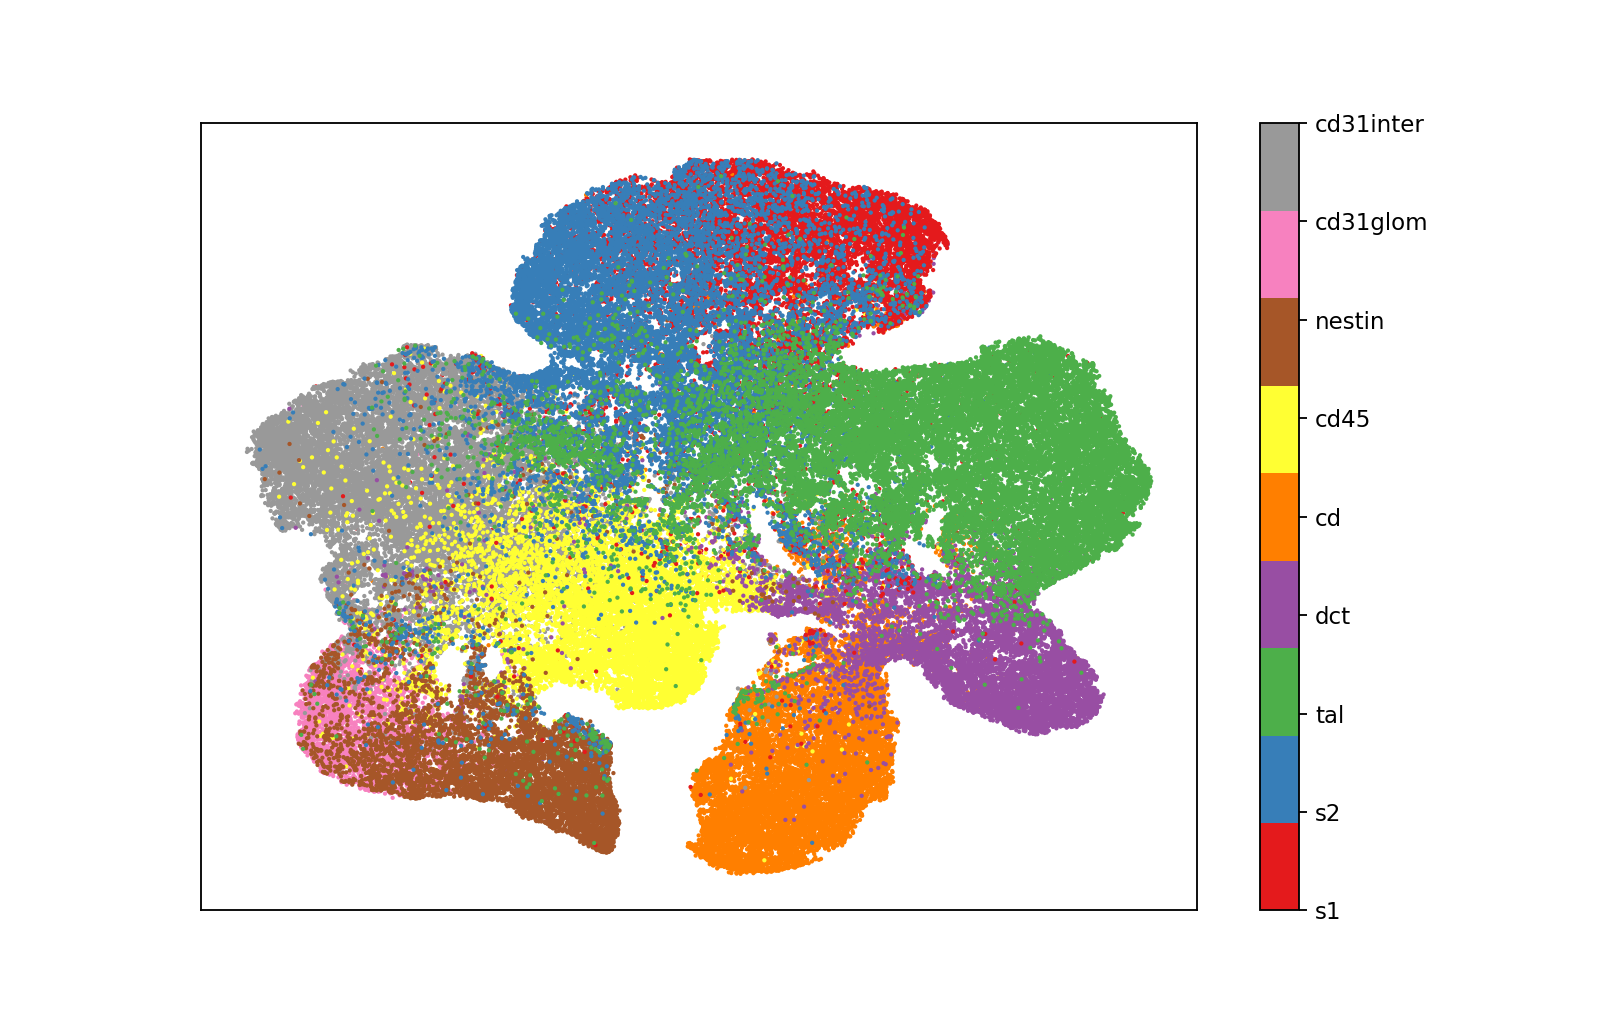

FINISHED PLOTTING


In [11]:
print(len(y))
my_tsne.features = fts
my_tsne.labels= lbs
my_tsne.plot_embedding(y)


#lr 200, perplexity 20, 1000iters

<IPython.core.display.Javascript object>


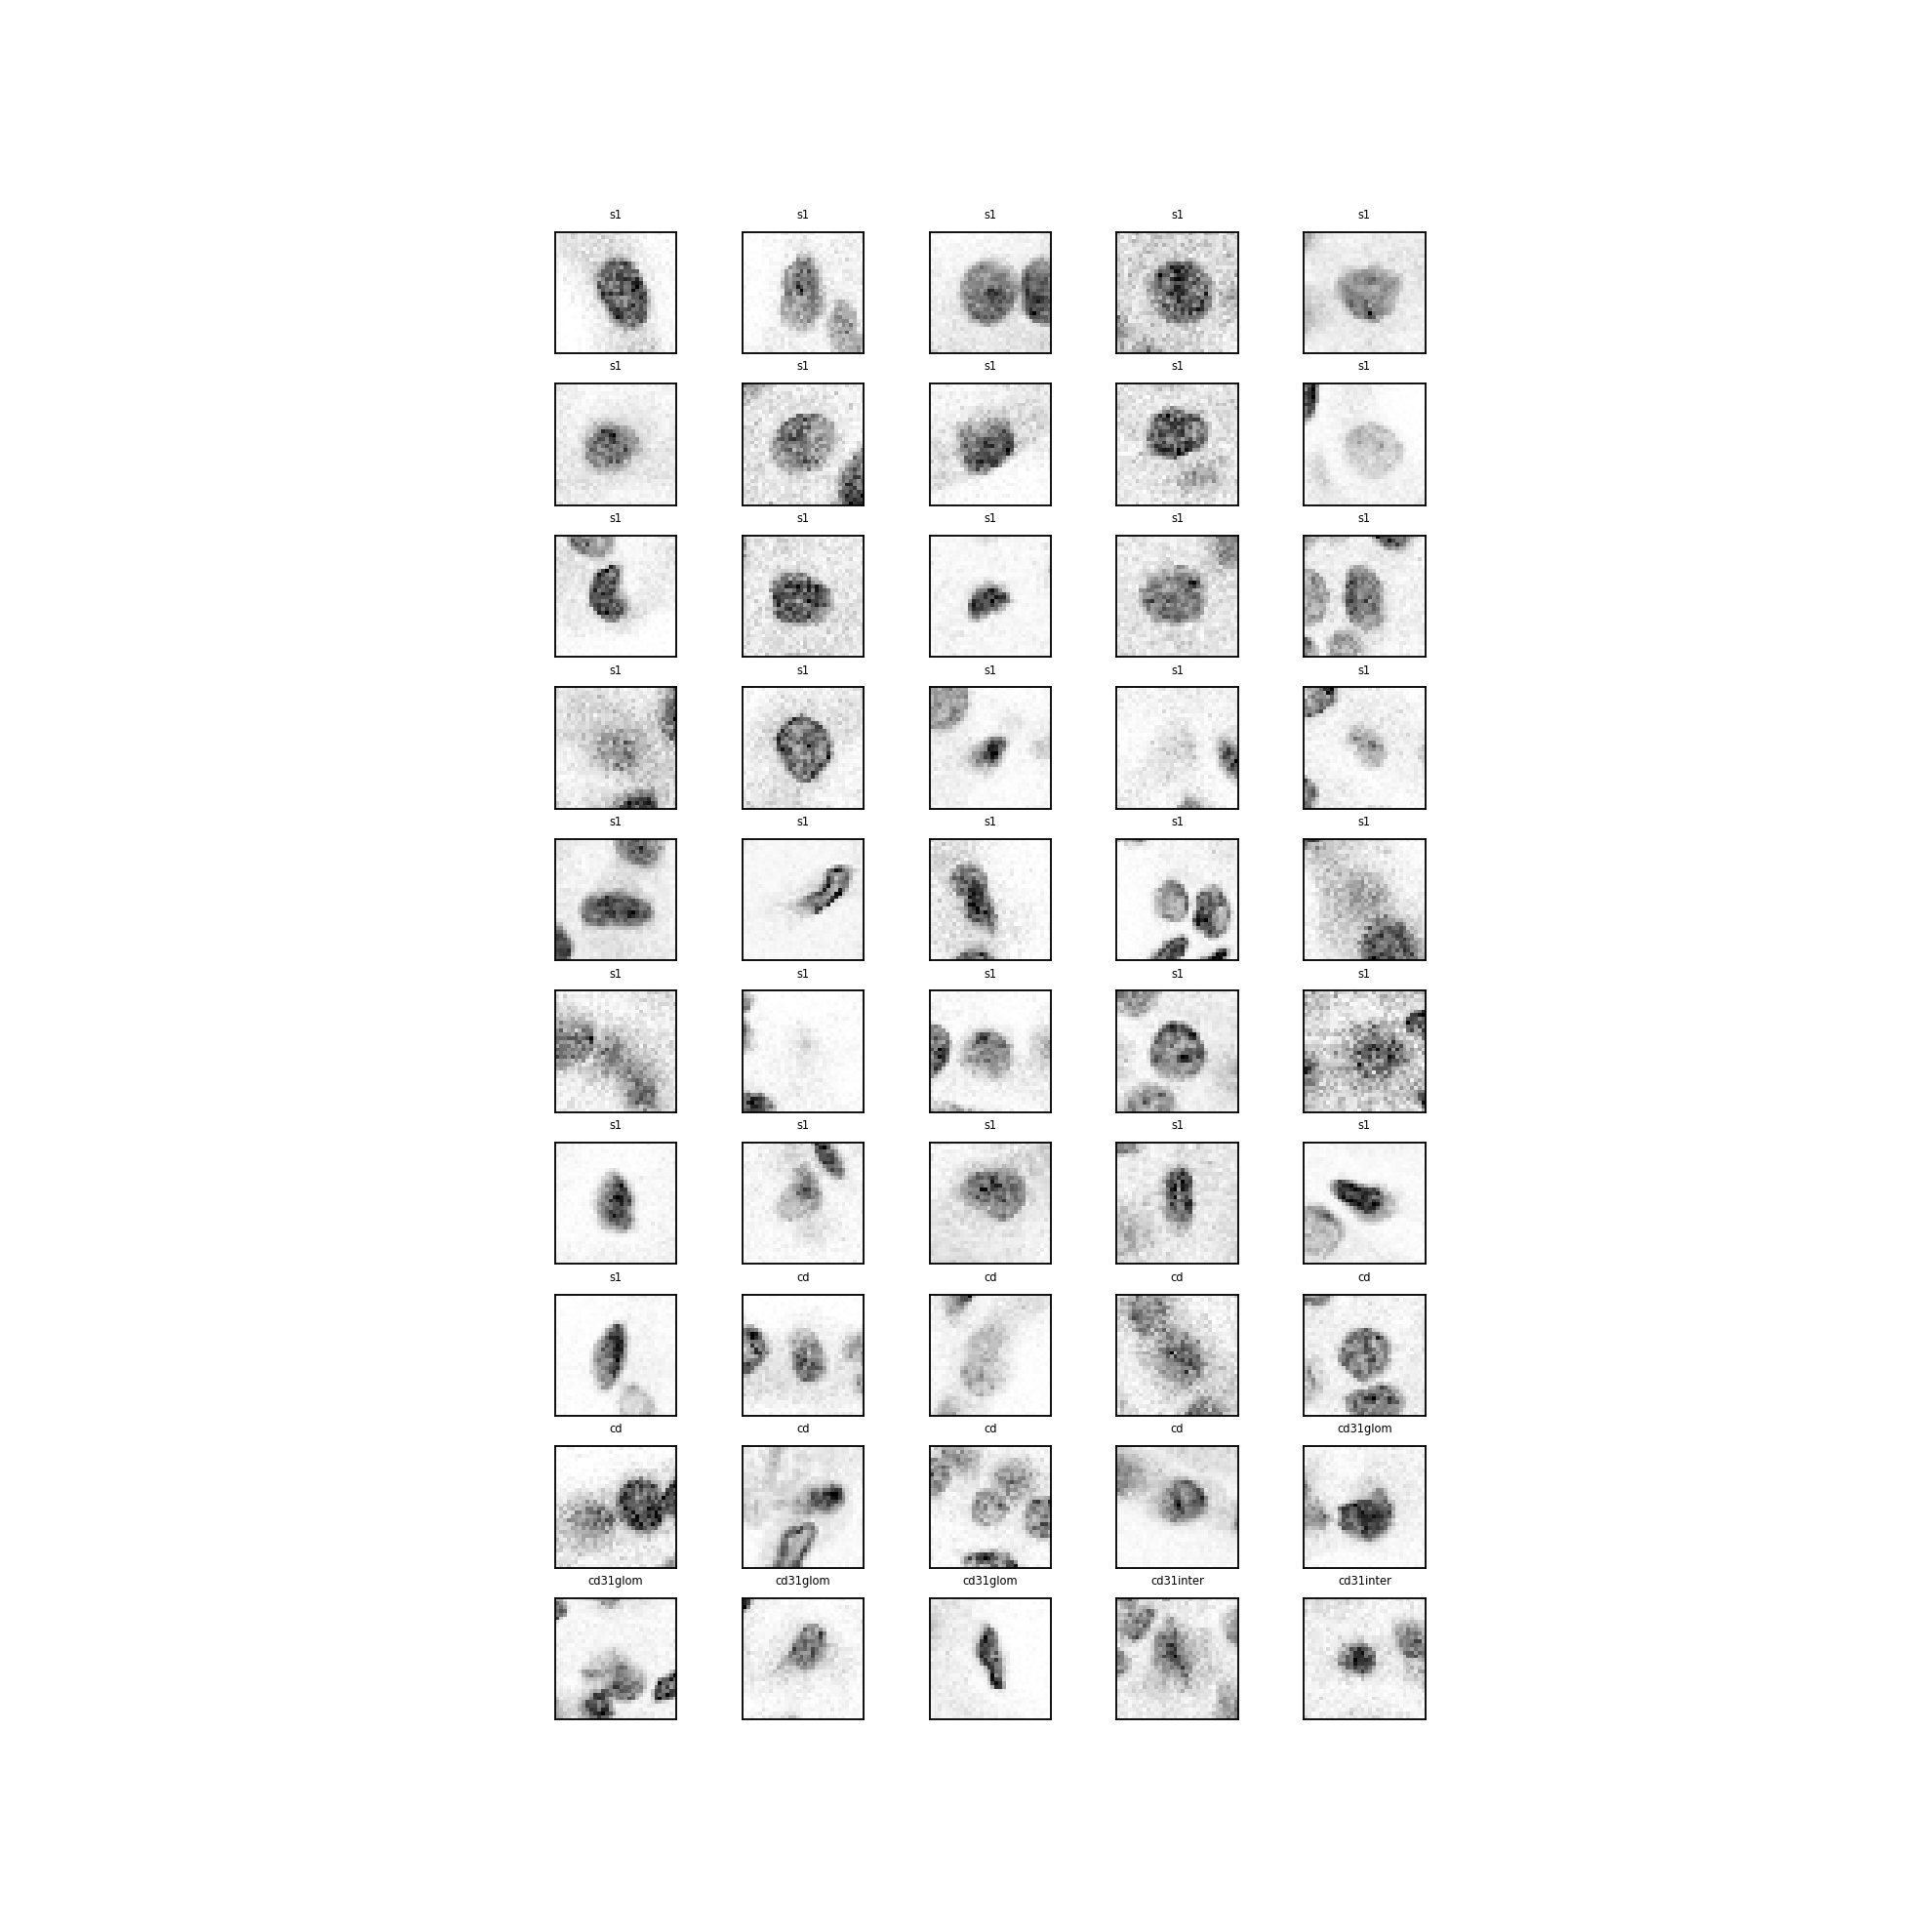

In [15]:
my_tsne.DISTANCE_THREHOLD = 1e-2
my_tsne.show_examples(y)